# IV Failure Classification with Neural Networks
This notebook demonstrates the use of the `pvops.iv.models.nn` module for classification of faults.

In [1]:
import os
import sys

from pvops.iv import simulator, extractor, preprocess
from pvops.iv.models import nn

Create iv column dictionary with format {pvops variable: user-specific column names}. This establishes a connection between the user's data columns and the pvops library.

In [2]:
iv_col_dict = {
    "mode": "mode",
    "current": "current",            # Populated in simulator
    "voltage": "voltage",            # Populated in simulator
    "irradiance": "E",               # Populated in simulator
    "temperature": "T",              # Populated in simulator
    "power": "power",                # Populated in preprocess
    "derivative": "derivative",      # Populated in feature_generation
    "current_diff": "current_diff",  # Populated in feature_generation
}

## Step 1: Collect your IV curves. 

In this case, we simulate some curves, but you can replace this step by reading in your own data, if wanted.

In [3]:
def define_failure_at_environment(sim, E, Tc, N_samples = 10):

    def namer(name):
        suffix = f"-{E}_{Tc}"
        return name + suffix
    
    sim.pristine_condition = {'identifier': 'pristine',
                              'E': E,
                              'Tc': Tc,
                              'Rsh_mult': 1,
                              'Rs_mult': 1,
                              'Io_mult': 1,
                              'Il_mult': 1,
                              'nnsvth_mult': 1,
                              }
    condition = {'identifier':namer('weathered_pristine')}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_weathered_pristine'))
    condition = {'identifier':namer('shade'),'Il_mult':0.6}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_shading'))
    condition = {'identifier':namer('cracking'),'Rs_mult':1.5}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_cracking'))

    dicts = {'Il_mult':{'mean': 0.6,
                        'std': 0.7,
                        'low': 0.33,
                        'upp': 0.95,
                        }
            }
    sim.generate_many_samples(namer('shade'), N_samples, dicts)

    dicts = {
            'Rs_mult':{'mean':1.3,
                        'std':0.6,
                        'low':1.1,
                        'upp':1.8
                        },
            'Rsh_mult':{'mean':0.5,
                        'std':0.6,
                        'low':0.3,
                        'upp':0.7
                        }
            }
    sim.generate_many_samples(namer('cracking'), N_samples, dicts)

    sim.build_strings({
                    namer('Partial Soiling (1M)'): [namer('Complete_weathered_pristine')]*11 + [namer('Complete_shading')]*1,
                    namer('Partial Soiling (6M)'): [namer('Complete_weathered_pristine')]*6 + [namer('Complete_shading')]*6,
                    namer('Cell cracking (4M)'): [namer('Complete_weathered_pristine')]*8 + [namer('Complete_cracking')]*4,
                    })
    return sim


In [4]:
import numpy as np

sim = simulator.Simulator(
                pristine_condition = {
                                        'identifier': 'pristine',
                                        'E': 1000,
                                        'Tc': 50,
                                        'Rsh_mult': 1,
                                        'Rs_mult': 1,
                                        'Io_mult': 1,
                                        'Il_mult': 1,
                                        'nnsvth_mult': 1,
                                    })

sim.build_strings({'Pristine array': ['pristine']*12})

Tc = 35
for E in np.arange(200,1100,100):
    for Tc in np.arange(35,60,5):
        define_failure_at_environment(sim, E, Tc, N_samples = 25)
sim.simulate()

Simulating cells:   0%|          | 0/136 [00:00<?, ?it/s]/home/klbonne/.local/bin/anaconda3/envs/pvops_dev/lib/python3.8/site-packages/scipy/optimize/_zeros_py.py:466: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 136/136 [00:00<00:00, 584452.20it/s]


In [5]:
df = sim.sims_to_df(focus=['string'], cutoff=True)
df.head()

,current,voltage,E,T,mode,level
0,"[9.214203000284689, 9.210691359222285, 9.20726...","[3.834932371660216e-12, 11.207809937682319, 22...",1000.0,50.0,Pristine array,string
1,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
2,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
3,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
4,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string


In [6]:
# Convert modes to be the discrete failure modes
df['mode'] = [x.split('-')[0] for x in df['mode']]

Visualize generated samples for each failure mode.


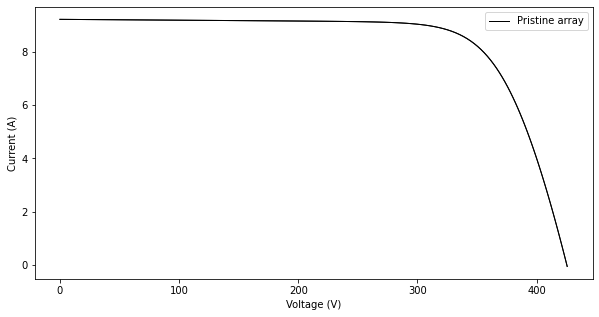

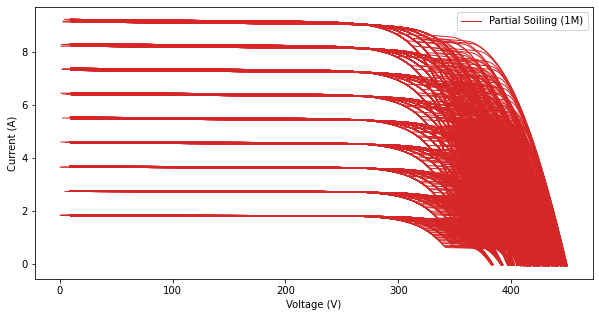

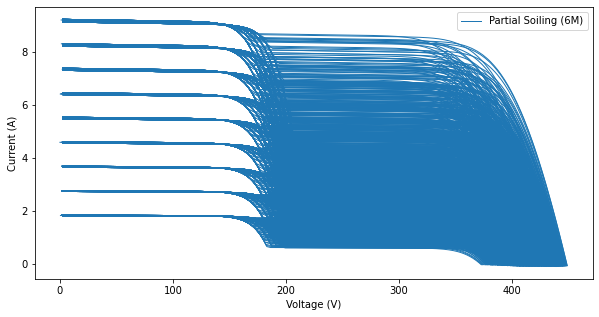

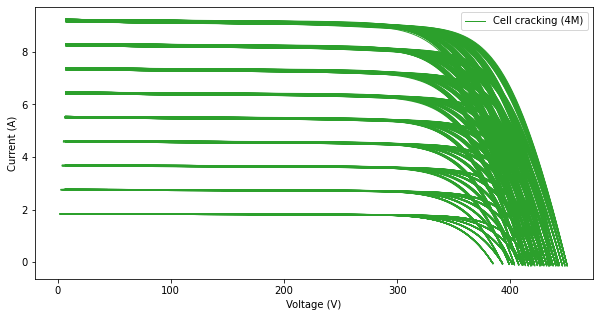

In [15]:
import matplotlib.pyplot as plt

colors = ['k', 'tab:red', 'tab:blue', 'tab:green']

# plt.figure(figsize=(12,8))
unique_modes = df['mode'].unique()
for md_idx, md in enumerate(unique_modes):
    plt.figure(figsize=(10,5))

    subdf = df[df['mode'] == md]
    i = 0
    for ind,row in subdf.iterrows():
        if i == 0:
            plt.plot(row['voltage'], row['current'], linewidth=1, color=colors[md_idx], label=md)
        plt.plot(row['voltage'], row['current'], linewidth=1, color=colors[md_idx])
        i += 1
        plt.legend()
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")

Next, process the data for irradiance and temperature correction, 
and normalize the axes. Shuffle the data in preparation for classification.


In [8]:
prep_df = preprocess.preprocess(df, 0.05, iv_col_dict, resmpl_cutoff=0.03,
                                correct_gt=True, normalize_y=False,
                                CECmodule_parameters=sim.module_parameters,
                                n_mods=12, gt_correct_option=3)
# Shuffle
bigdf = prep_df.sample(frac=1).reset_index(drop=True)
bigdf.dropna(inplace=True)
bigdf.head(n=2)


,mode,current,voltage,power,E,T
0,Partial Soiling (6M),"[9.208600987136746, 9.195882051686299, 9.18315...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.2762580296141024, 0.735670564134904, 1.1938...",600.0,50.0
1,Partial Soiling (6M),"[9.212759790227, 9.200363798497587, 9.18796074...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.27638279370681, 0.736029103879807, 1.194434...",200.0,40.0


In [9]:
# Feature generation
feat_df = nn.feature_generation(bigdf, iv_col_dict)
feat_df.head(n=2)

,mode,current,voltage,power,E,T,current_diff,derivative
0,Partial Soiling (6M),"[9.208600987136746, 9.195882051686299, 9.18315...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.2762580296141024, 0.735670564134904, 1.1938...",600.0,50.0,"[0.0015998674001220792, 0.007648488303704681, ...","[0.0, -0.012718935450447333, -0.01272509254493..."
1,Partial Soiling (6M),"[9.212759790227, 9.200363798497587, 9.18796074...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.27638279370681, 0.736029103879807, 1.194434...",200.0,40.0,"[-0.0025589356901321025, 0.0031667414924161363...","[0.0, -0.01239599172941297, -0.012403058265777..."


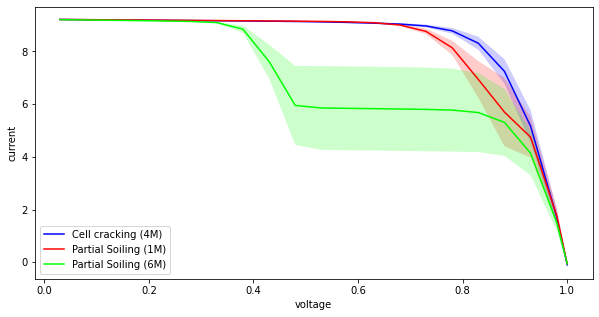

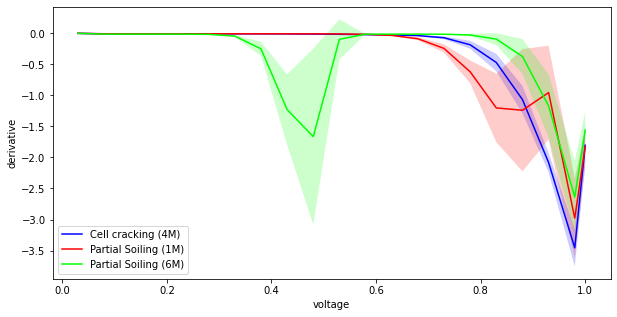

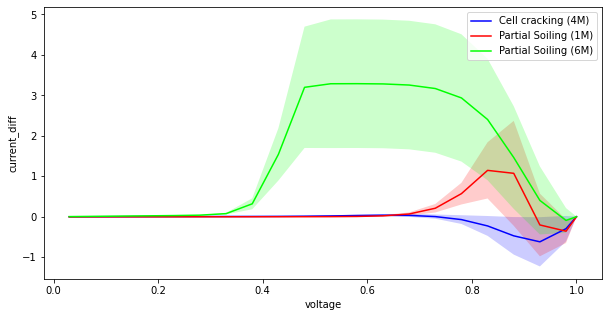

In [10]:
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['current'],
                       iv_col_dict)
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['derivative'],
                       iv_col_dict)
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['current_diff'],
                       iv_col_dict)

In [11]:
# To provide a clean output, we filter warnings. We encourage you to *remove* this filter.
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

nn_config = {
    # NN parameters
    "model_choice": "1DCNN", # or "LSTM_multihead"
    "params": ['current', 'power', 'derivative', 'current_diff'],
    "dropout_pct": 0.5,
    "verbose": 1,
    # Training parameters
    "train_size": 0.9,
    "shuffle_split": True,
    "balance_tactic": 'truncate',
    "n_CV_splits": 5,
    "batch_size": 8,
    "max_epochs": 100,
    # LSTM parameters
    "use_attention_lstm": False,
    "units": 50,
    # 1DCNN parameters
    "nfilters": 64,
    "kernel_size": 12,
}

nn.classify_curves(feat_df, iv_col_dict, nn_config)

Balance data by mode:
	[Class Partial Soiling (1M)]: Resampled, 1170 == 1170
	[Class Partial Soiling (6M)]: Resampled, 1170 == 1170
	[Class Cell cracking (4M)]: Resampled, 1170 == 1170
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            3136      
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 100)               64100     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Tot

(<pvops.iv.models.nn.IVClassifier at 0x7f149043b6a0>,
                       mode                                            current  \
 546   Partial Soiling (6M)  [9.210855299765184, 9.198167892156352, 9.18547...   
 308   Partial Soiling (6M)  [9.203746007748741, 9.190451335406063, 9.17714...   
 1985  Partial Soiling (1M)  [9.213877334936674, 9.206654363996044, 9.19943...   
 1150  Partial Soiling (6M)  [9.209214372643126, 9.196397972209853, 9.18357...   
 1354  Partial Soiling (6M)  [9.204381949246688, 9.191145738106723, 9.17790...   
 ...                    ...                                                ...   
 517     Cell cracking (4M)  [9.211188954334622, 9.201364333368181, 9.19153...   
 1913    Cell cracking (4M)  [9.214349750807305, 9.206652654143795, 9.19893...   
 1402  Partial Soiling (1M)  [9.218452597921566, 9.211327251671754, 9.20420...   
 585   Partial Soiling (6M)  [9.204333662518495, 9.191016941963325, 9.17769...   
 1599    Cell cracking (4M)  [9.216763526435